In [1]:
import numpy as np
import pandas as pd
import sklearn
from sklearn.metrics import classification_report,accuracy_score
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
import scipy
from pylab import rcParams
import matplotlib.pyplot as plot
import seaborn as sns
import time

rcParams['figure.figsize'] = 14, 8
RANDOM_SEED = 42
LABELS = ["Normal", "Fraud"]

In [2]:
# Importing Kaggle dataset ---> creditcard.csv
data = pd.read_csv('creditcard.csv',sep=',') 

#Head function is used to get first n rows
data.head(5)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [3]:
# info() is used print a concise summary of data frame like index data type and column data type
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [4]:
# isnull() detects missing values in the given dataset
data.isnull().values.any()

False

Text(0, 0.5, 'Frequency of classes of Transaction')

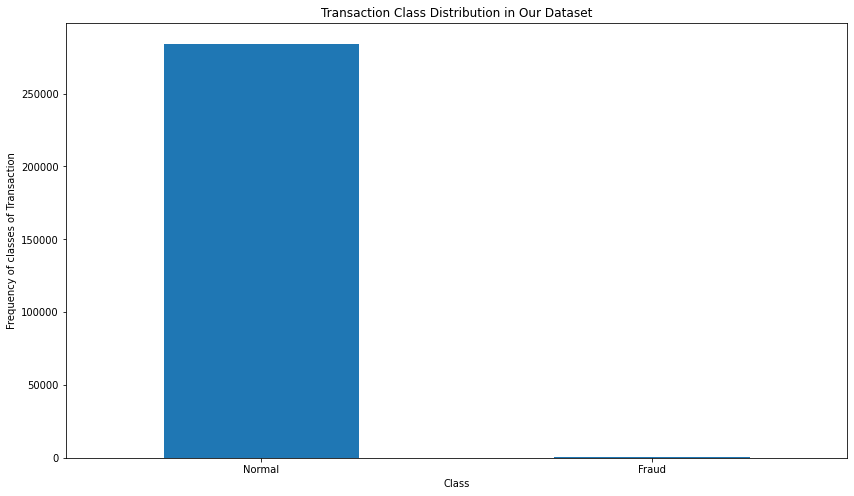

In [5]:
# value_counts() function return a Series containing counts of unique values. 
# The resulting object will be in descending order so that the first element is the most frequently-occurring element. 
# It will exclude null values by default
count_classes = pd.value_counts(data['Class'], sort = True)

# Plotting bar graph
count_classes.plot(kind = 'bar', rot=0)

plot.title("Transaction Class Distribution in Our Dataset")

plot.xticks(range(2), LABELS)

plot.xlabel("Class")

plot.ylabel("Frequency of classes of Transaction")

In [6]:
# Get the Fraud and the Normal dataset  

# Fraud --> class == 1
fraud = data[data['Class']==1]

# Normal --> class == 0
normal = data[data['Class']==0]

In [7]:
# Printing dimensions of fraud and normal dataset
print(fraud.shape,normal.shape)

(492, 31) (284315, 31)


In [8]:
# Printing fraud dataset
fraud.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
541,406.0,-2.312227,1.951992,-1.609851,3.997906,-0.522188,-1.426545,-2.537387,1.391657,-2.770089,...,0.517232,-0.035049,-0.465211,0.320198,0.044519,0.177840,0.261145,-0.143276,0.00,1
623,472.0,-3.043541,-3.157307,1.088463,2.288644,1.359805,-1.064823,0.325574,-0.067794,-0.270953,...,0.661696,0.435477,1.375966,-0.293803,0.279798,-0.145362,-0.252773,0.035764,529.00,1
4920,4462.0,-2.303350,1.759247,-0.359745,2.330243,-0.821628,-0.075788,0.562320,-0.399147,-0.238253,...,-0.294166,-0.932391,0.172726,-0.087330,-0.156114,-0.542628,0.039566,-0.153029,239.93,1
6108,6986.0,-4.397974,1.358367,-2.592844,2.679787,-1.128131,-1.706536,-3.496197,-0.248778,-0.247768,...,0.573574,0.176968,-0.436207,-0.053502,0.252405,-0.657488,-0.827136,0.849573,59.00,1
6329,7519.0,1.234235,3.019740,-4.304597,4.732795,3.624201,-1.357746,1.713445,-0.496358,-1.282858,...,-0.379068,-0.704181,-0.656805,-1.632653,1.488901,0.566797,-0.010016,0.146793,1.00,1


In [9]:
# Printing normal dataset
normal.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [10]:
# We need to analyze more amount of information from the fraudulent transaction data
# describe() is used to view some basic statistical details like percentile, mean, std of the fraudulent dataset 
fraud.Amount.describe()

count     492.000000
mean      122.211321
std       256.683288
min         0.000000
25%         1.000000
50%         9.250000
75%       105.890000
max      2125.870000
Name: Amount, dtype: float64

In [11]:
# We need to analyze more amount of information from the normal transaction data
# describe() is used to view some basic statistical details like percentile, mean, std of the normal dataset 
normal.Amount.describe()

count    284315.000000
mean         88.291022
std         250.105092
min           0.000000
25%           5.650000
50%          22.000000
75%          77.050000
max       25691.160000
Name: Amount, dtype: float64

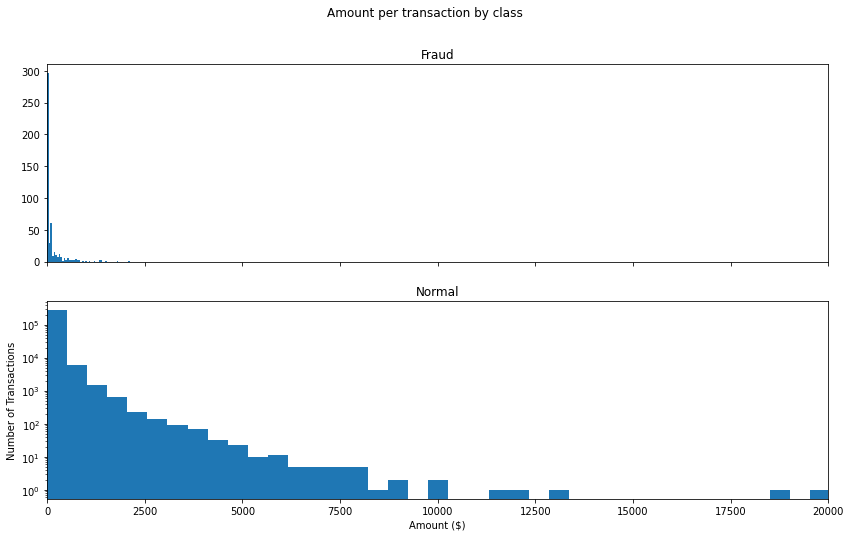

In [12]:
# Plotting a histogram of fraud and normal transactions

f, (ax1, ax2) = plot.subplots(2, 1, sharex=True)
f.suptitle('Amount per transaction by class')
bins = 50
ax1.hist(fraud.Amount, bins = bins)
ax1.set_title('Fraud')
ax2.hist(normal.Amount, bins = bins)
ax2.set_title('Normal')
plot.xlabel('Amount ($)')
plot.ylabel('Number of Transactions')
plot.xlim((0, 20000))
plot.yscale('log')
plot.show();

# No.of transaction are more for smaller amounts

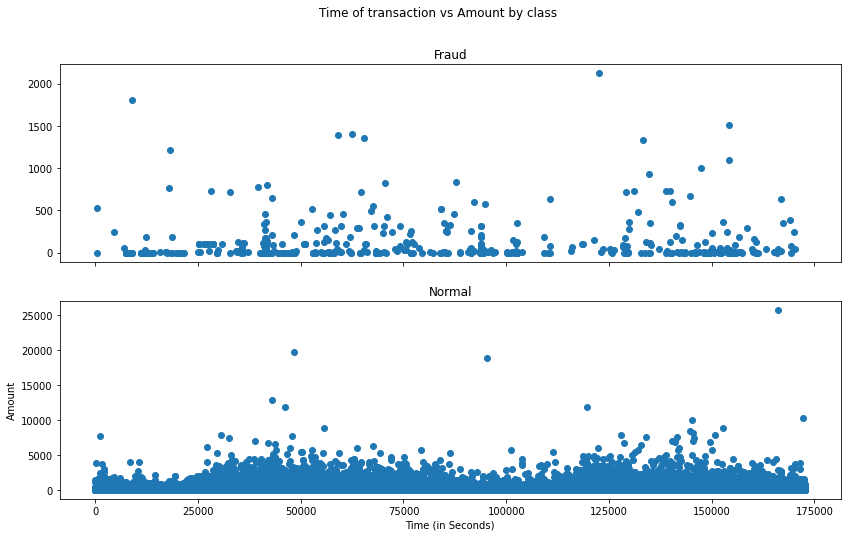

In [13]:
# Plotting scatter plot for fraud and normal dataset
f, (ax1, ax2) = plot.subplots(2, 1, sharex=True)
f.suptitle('Time of transaction vs Amount by class')
ax1.scatter(fraud.Time, fraud.Amount)
ax1.set_title('Fraud')
ax2.scatter(normal.Time, normal.Amount)
ax2.set_title('Normal')
plot.xlabel('Time (in Seconds)')
plot.ylabel('Amount')
plot.show()

# It shows that fraud transactions are more scattered and they act as outliers.

In [14]:
# Taking a sample of 10% of data
sampledata= data.sample(frac = 0.1,random_state=1)

# Dimensions of sample transactions of dataset
sampledata.shape

(28481, 31)

In [15]:
# Dimensions of total transactions of dataset 
data.shape

(284807, 31)

In [16]:
#Determine the number of fraud and Normal transactions in the dataset

Fraud = sampledata[sampledata['Class']==1]

Normal = sampledata[sampledata['Class']==0]

# Finding outlier fraction for sample
outlier_fraction = len(Fraud)/float(len(Normal))

In [17]:
print(outlier_fraction)

# Printing no. of fraud and normal transactions from samples
print("Fraud Transactions : {}".format(len(Fraud)))

print("Normal Transactions : {}".format(len(Normal)))

0.0017234102419808666
Fraud Transactions : 49
Normal Transactions : 28432


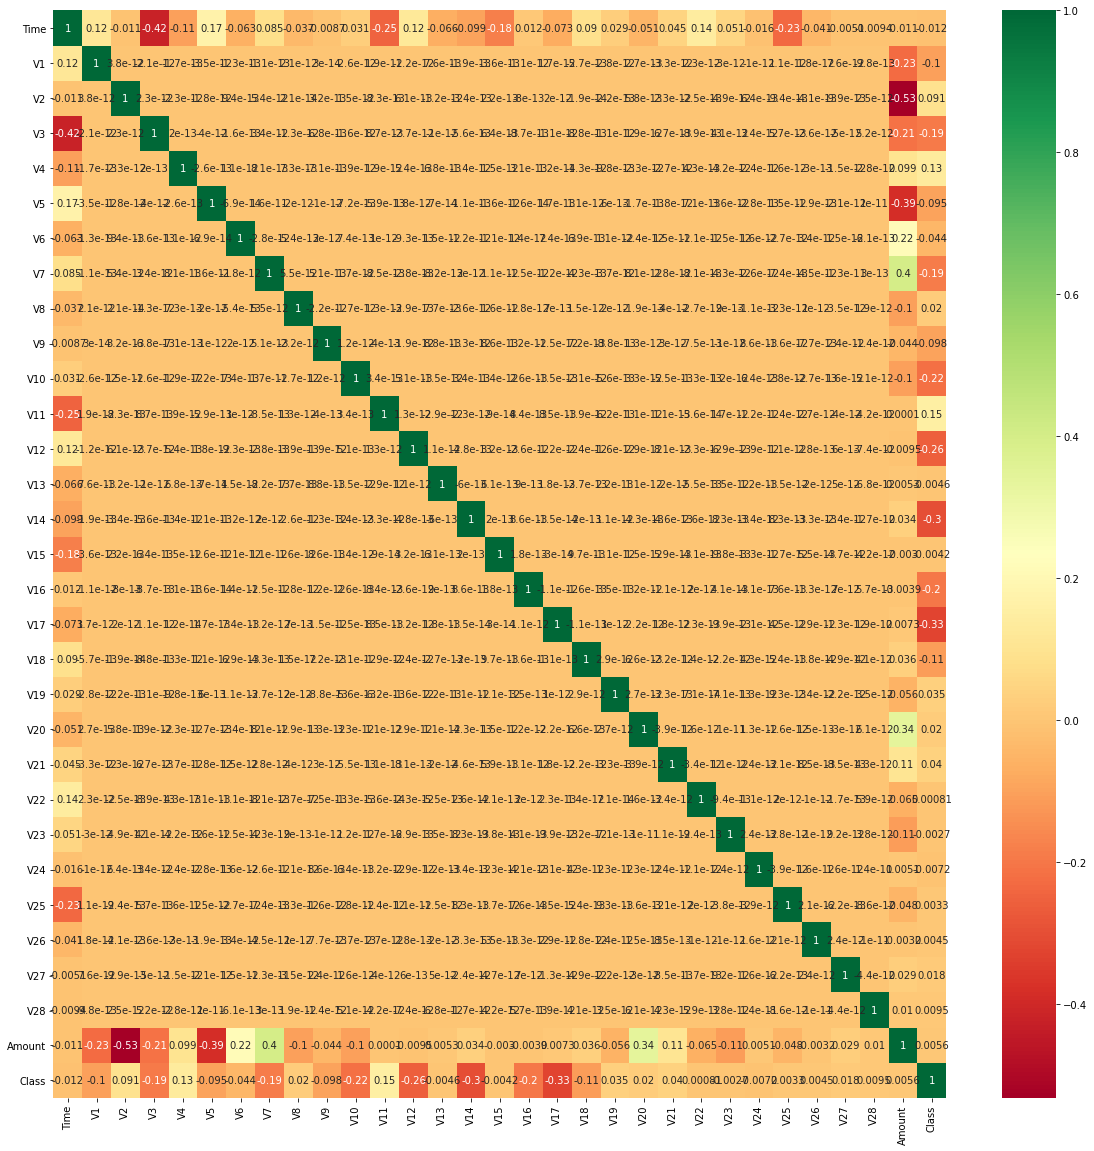

In [18]:
# Finding Correlation between fraud and normal transactions
# Get correlations of each features in dataset

corrmat = sampledata.corr()
top_corr_features = corrmat.index

# figsize attribute allows us to specify width and height in unit inches 
plot.figure(figsize=(20,20))
#plot heat map
g=sns.heatmap(data[top_corr_features].corr(),annot=True,cmap="RdYlGn")

In [19]:
#Create independent and Dependent Features
columns = sampledata.columns.tolist() # tolist() converting into array

# Filter the columns to remove data of class column as it can not be use in purpose of analysis
columns = [c for c in columns if c not in ["Class"]]
# Store the variable we are predicting 
target = "Class"

# Random_state = any int value means every time when you run your program you will get the same output 
# Because of splitting between train and test does not varies within.   
state = np.random.RandomState(42)
X = sampledata[columns] # Independent Variable
Y = sampledata[target]  # Dependent Variable

#  uniform() method returns a random floating number between the two specified numbers (both included). 
X_outliers = state.uniform(low=0, high=1, size=(X.shape[0], X.shape[1]))
# Print the shapes of X & Y
print(X.shape)
print(Y.shape)

(28481, 30)
(28481,)


In [20]:
data.shape

(284807, 31)

In [21]:
classifiers = {
    "Isolation Forest":IsolationForest(n_estimators=100, max_samples=len(X), 
                                       contamination=outlier_fraction,random_state=state, verbose=0),
    "Local Outlier Factor":LocalOutlierFactor(n_neighbors=20, algorithm='auto', 
                                              leaf_size=30, metric='minkowski',
                                              p=2, metric_params=None, contamination=outlier_fraction),
}

In [22]:
full_data=data
full_data=full_data.sample(frac=1)#randomize the whole dataset,
#frac=1-->Fraction of axis items to return. 
full_features=full_data.drop(["Time","Class"],axis=1) #axis=1-->denotes columns
full_labels=pd.DataFrame(full_data[["Class"]])
# DataFrame is a 2-dimensional labeled data structure with columns of potentially different types.
full_features_array=full_features.values
#values-->Only the values in the DataFrame will be returned, the axes labels will be removed.
full_labels_array=full_labels.values
train_features,test_features,train_labels,test_labels=train_test_split(full_features_array,full_labels_array,train_size=0.90)
train_features=normalize(train_features)
test_features=normalize(test_features)

In [23]:
#k_means_classification --> k_means_clustering, confsion_matrix, reassigning
kmeans=KMeans(n_clusters=2,random_state=0,algorithm="elkan",max_iter=10000)
kmeans.fit(train_features)
kmeans_predicted_train_labels=kmeans.predict(train_features)

In [24]:
#confusion matrix
# tn fp
# fn tp
#tn --> true negatives
#fp --> false positives
#fn --> false negatives
#tp --> true positives
tn,fp,fn,tp=confusion_matrix(train_labels,kmeans_predicted_train_labels).ravel()

In [25]:
tn,fp,fn,tp=confusion_matrix(train_labels,kmeans_predicted_train_labels).ravel()
reassignflag=False
if tn+tp<fn+fp:
	# clustering is opposite of original classification
	reassignflag=True
kmeans_predicted_test_labels=kmeans.predict(test_features)
if reassignflag:
	kmeans_predicted_test_labels=1-kmeans_predicted_test_labels
#calculating confusion matrix for kmeans
tn,fp,fn,tp=confusion_matrix(test_labels,kmeans_predicted_test_labels).ravel()
#scoring kmeans
kmeans_accuracy_score=accuracy_score(test_labels,kmeans_predicted_test_labels)
kmeans_precison_score=precision_score(test_labels,kmeans_predicted_test_labels)
kmeans_recall_score=recall_score(test_labels,kmeans_predicted_test_labels)
kmeans_f1_score=f1_score(test_labels,kmeans_predicted_test_labels)

In [26]:
#k_nearest_neighbours_classification
knn=KNeighborsClassifier(n_neighbors=5,algorithm="kd_tree")
knn.fit(train_features,train_labels.ravel())
knn_predicted_test_labels=knn.predict(test_features)

In [27]:
#calculating confusion matrix for knn
tn1,fp1,fn1,tp1=confusion_matrix(test_labels,knn_predicted_test_labels).ravel()

In [28]:
knn_accuracy_score=accuracy_score(test_labels,knn_predicted_test_labels)
knn_precison_score=precision_score(test_labels,knn_predicted_test_labels)
knn_recall_score=recall_score(test_labels,knn_predicted_test_labels)
knn_f1_score=f1_score(test_labels,knn_predicted_test_labels)

In [29]:
n_outliers = len(Fraud)
for i, (clf_name,clf) in enumerate(classifiers.items()):
    #Fit the data and tag outliers
    if clf_name == "Local Outlier Factor":
        y_pred = clf.fit_predict(X)
        scores_prediction = clf.negative_outlier_factor_
        
    else:    
        clf.fit(X)
        scores_prediction = clf.decision_function(X)
        y_pred = clf.predict(X)
    #Reshape the prediction values to 0 for Normal transactions , 1 for Fraud transactions
    y_pred[y_pred == 1] = 0
    y_pred[y_pred == -1] = 1
    n_errors = (y_pred != Y).sum()
    # Run Classification Metrics
    print("{}".format(clf_name))
    print("Accuracy Score :")
    a=accuracy_score(Y,y_pred)
    if clf_name == "Local Outlier Factor":
        lof_a=a
    else:
        if_a=a
    print(accuracy_score(Y,y_pred))
    print("Classification Report :")
    print(classification_report(Y,y_pred))
print("")
print("K-Means:")
print("Confusion Matrix")
print("tn =",tn,"fp =",fp)
print("fn =",fn,"tp =",tp)
print("Accuracy Score :")
print(kmeans_accuracy_score)
print("Classification Report :")
print(classification_report(test_labels,kmeans_predicted_test_labels))
print("")
print("K-Nearest Neighbours:")
print("Confusion Matrix")
print("tn =",tn1,"fp =",fp1)
print("fn =",fn1,"tp =",tp1)
print("Accuracy Score :")
print(knn_accuracy_score)
print("Classification Report :")
print(classification_report(test_labels,knn_predicted_test_labels))

Isolation Forest
Accuracy Score :
0.9974368877497279
Classification Report :
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     28432
           1       0.26      0.27      0.26        49

    accuracy                           1.00     28481
   macro avg       0.63      0.63      0.63     28481
weighted avg       1.00      1.00      1.00     28481

Local Outlier Factor
Accuracy Score :
0.9965942207085425
Classification Report :
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     28432
           1       0.02      0.02      0.02        49

    accuracy                           1.00     28481
   macro avg       0.51      0.51      0.51     28481
weighted avg       1.00      1.00      1.00     28481


K-Means:
Confusion Matrix
tn = 22717 fp = 5715
fn = 30 tp = 19
Accuracy Score :
0.7982865770162565
Classification Report :
              precision    recall  f1-score   support

         

In [30]:
print("Comparing accuracy of all the algorithms:")
acc=[lof_a,if_a,kmeans_accuracy_score,knn_accuracy_score]
max_acc=max(acc)
if max_acc==lof_a:
    print("LOF has the highest accuracy of:"+str(lof_a))
elif max_acc==if_a:
    print("Isolation Forest has the highest accuracy of:"+str(if_a))
elif max_acc==kmeans_accuracy_score:
    print("Kmeans has the highest accuracy of:"+str(kmeans_accuracy_score))
else:
    print("KNN has the highest accuracy of:"+str(knn_accuracy_score))




Comparing accuracy of all the algorithms:
KNN has the highest accuracy of:0.9992977774656788
